# Advertisement optimization using Reinforcement Learning

## Upper Confidence Bound (UCB)

UCB - Rounds: 100, Total Reward: 13, Average Reward per Round: 0.1300, Optimal Ad Selection Rate: 0.1300
UCB - Rounds: 500, Total Reward: 60, Average Reward per Round: 0.1200, Optimal Ad Selection Rate: 0.1580
UCB - Rounds: 1000, Total Reward: 155, Average Reward per Round: 0.1550, Optimal Ad Selection Rate: 0.2870
UCB - Rounds: 2000, Total Reward: 331, Average Reward per Round: 0.1655, Optimal Ad Selection Rate: 0.3425
UCB - Rounds: 5000, Total Reward: 996, Average Reward per Round: 0.1992, Optimal Ad Selection Rate: 0.5174
UCB - Rounds: 10000, Total Reward: 2178, Average Reward per Round: 0.2178, Optimal Ad Selection Rate: 0.6323


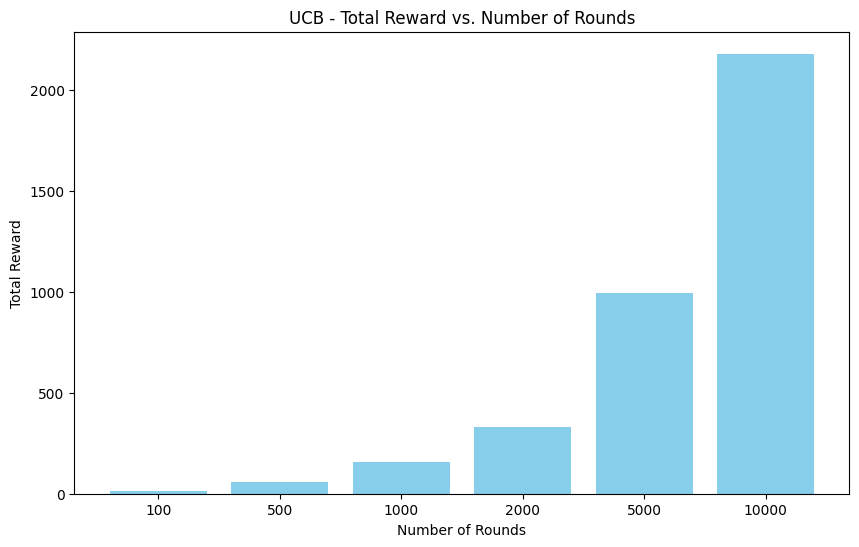

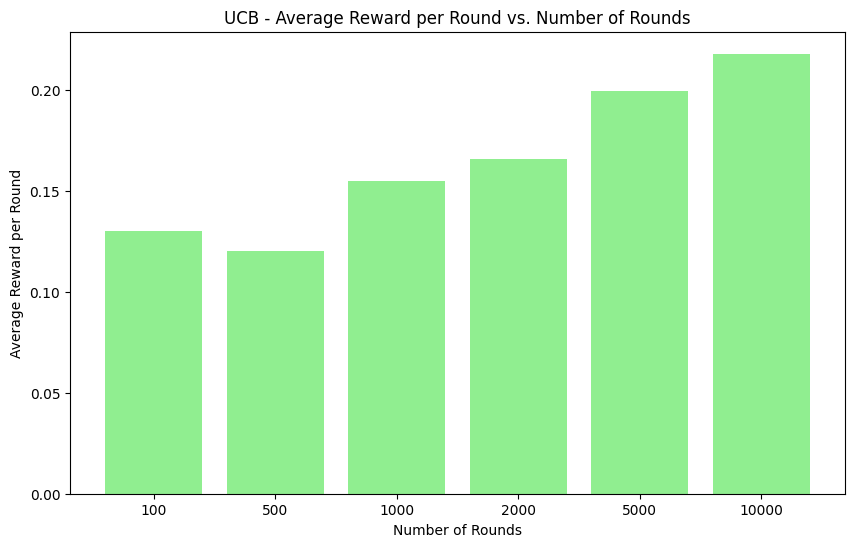

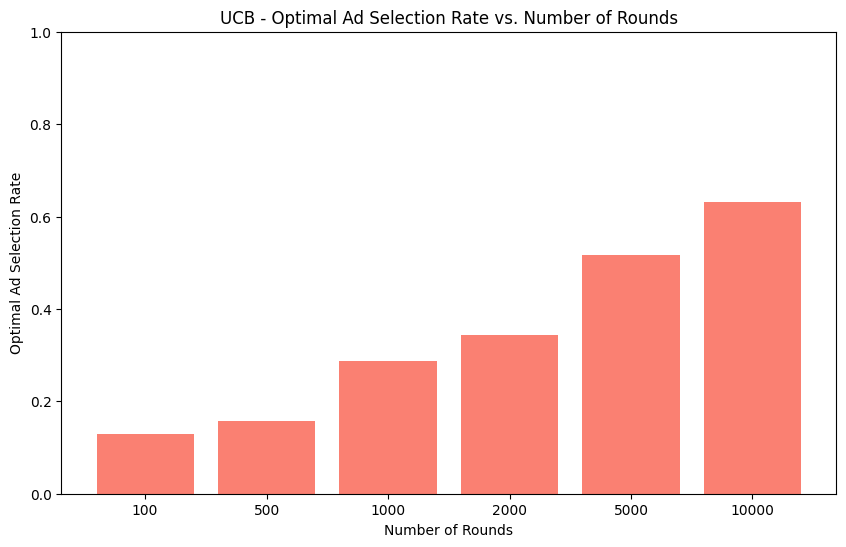

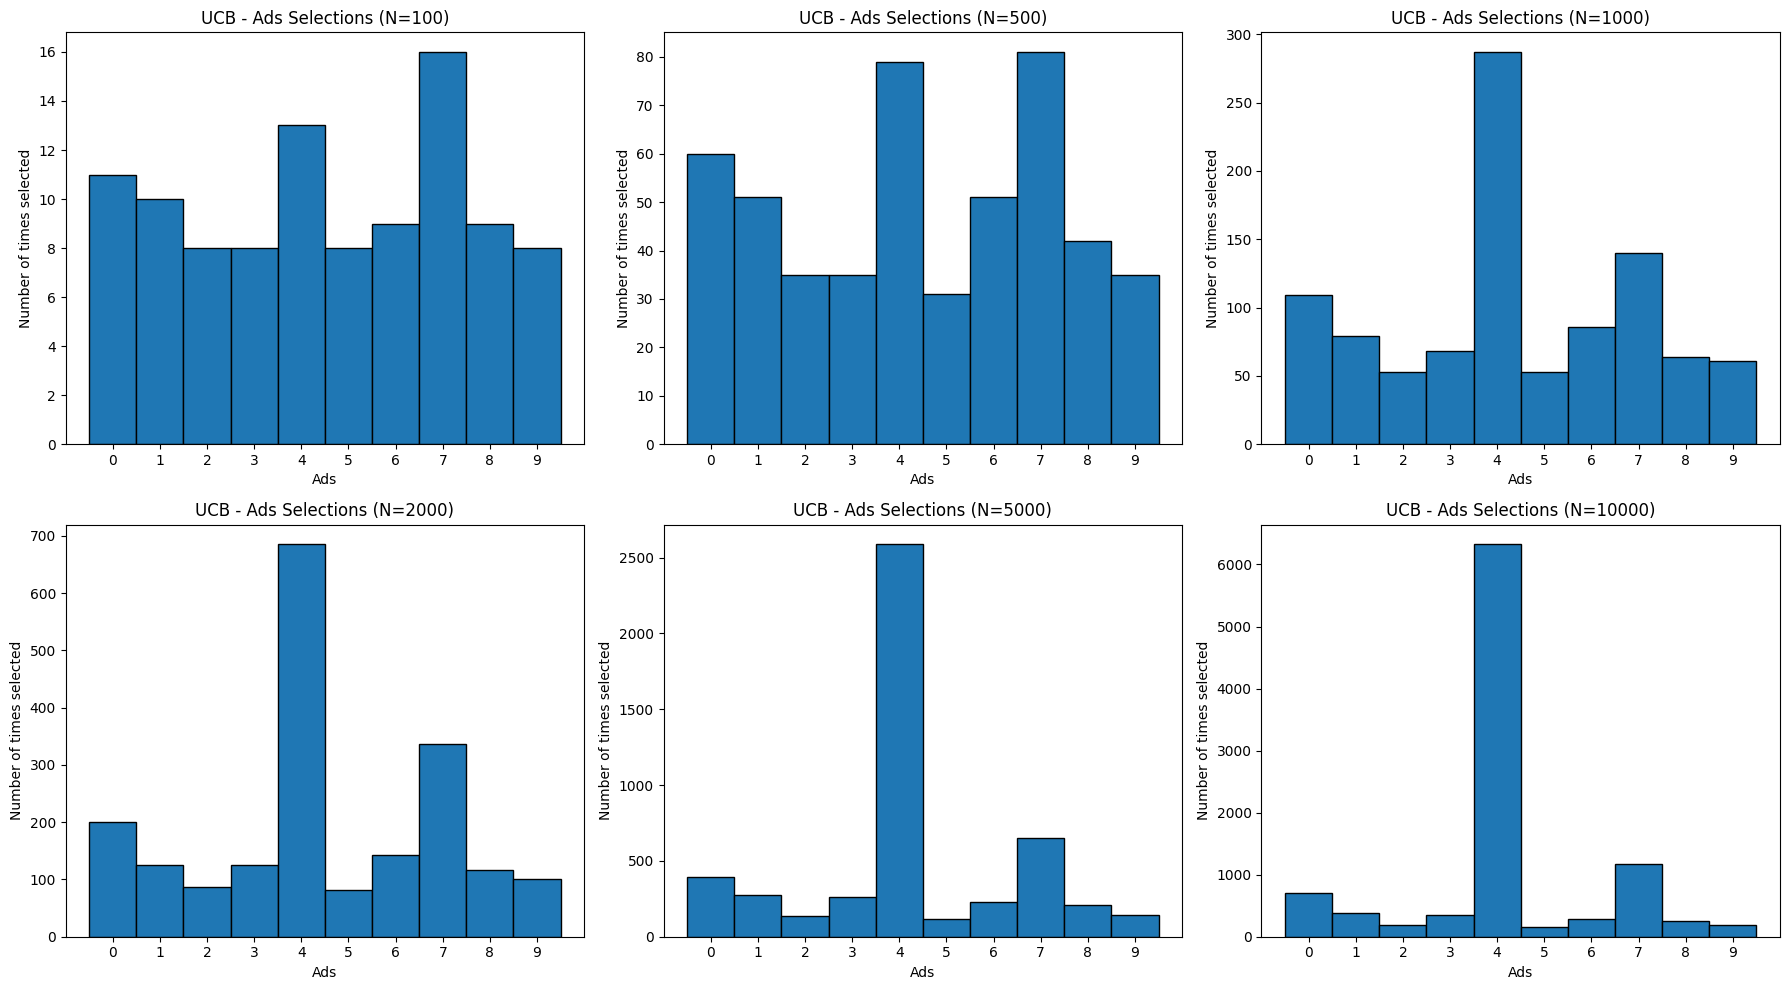

In [59]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os

# Create the outputs directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# Import dataset
dataset = pd.read_csv('raw_data/Ads_CTR_Optimisation.csv')

# Function to run UCB for a given number of rounds
def run_ucb(N, d):
    ads_selected = []
    numbers_of_selections = [0] * d
    sums_of_rewards = [0] * d
    total_reward = 0
    optimal_ad = np.argmax(dataset.mean().values)
    optimal_ad_selections = []
    for n in range(0, N):
        ad = 0
        max_upper_bound = 0
        for i in range(0, d):
            if (numbers_of_selections[i] > 0):
                average_reward = sums_of_rewards[i] / numbers_of_selections[i]
                delta_i = math.sqrt(3/2 * math.log(n + 1) / numbers_of_selections[i])
                upper_bound = average_reward + delta_i
            else:
                upper_bound = 1e400  # Set to a large number to ensure selection
            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound
                ad = i
        ads_selected.append(ad)
        numbers_of_selections[ad] += 1
        reward = dataset.values[n % len(dataset), ad]
        sums_of_rewards[ad] += reward
        total_reward += reward
        # Record if the optimal ad was selected
        optimal_ad_selections.append(int(ad == optimal_ad))
    # Calculate the optimal ad selection rate
    optimal_selection_rate = sum(optimal_ad_selections) / N
    # Calculate the average reward per round
    average_reward_per_round = total_reward / N
    return total_reward, average_reward_per_round, optimal_selection_rate, ads_selected

# Testing different numbers of rounds for UCB
rounds = [100, 500, 1000, 2000, 5000, 10000]
d = len(dataset.columns)
ucb_total_rewards = []
ucb_average_rewards_per_round = []
ucb_optimal_ad_selection_rates = []
ucb_ads_selected_list = []

for N in rounds:
    total_reward, avg_reward_per_round, optimal_selection_rate, ads_selected = run_ucb(N, d)
    ucb_total_rewards.append(total_reward)
    ucb_average_rewards_per_round.append(avg_reward_per_round)
    ucb_optimal_ad_selection_rates.append(optimal_selection_rate)
    ucb_ads_selected_list.append(ads_selected)
    print(f"UCB - Rounds: {N}, Total Reward: {total_reward}, Average Reward per Round: {avg_reward_per_round:.4f}, Optimal Ad Selection Rate: {optimal_selection_rate:.4f}")

# Plotting Total Rewards as a Bar Plot for UCB
plt.figure(figsize=(10, 6))
plt.bar([str(N) for N in rounds], ucb_total_rewards, color='skyblue')
plt.title('UCB - Total Reward vs. Number of Rounds')
plt.xlabel('Number of Rounds')
plt.ylabel('Total Reward')
plt.savefig('outputs/UCB_total_reward_vs_rounds.png')
plt.show()
plt.close()

# Plotting Average Reward per Round as a Bar Plot for UCB
plt.figure(figsize=(10, 6))
plt.bar([str(N) for N in rounds], ucb_average_rewards_per_round, color='lightgreen')
plt.title('UCB - Average Reward per Round vs. Number of Rounds')
plt.xlabel('Number of Rounds')
plt.ylabel('Average Reward per Round')
plt.savefig('outputs/UCB_average_reward_per_round_vs_rounds.png')
plt.show()
plt.close()

# Plotting Optimal Ad Selection Rate as a Bar Plot for UCB
plt.figure(figsize=(10, 6))
plt.bar([str(N) for N in rounds], ucb_optimal_ad_selection_rates, color='salmon')
plt.title('UCB - Optimal Ad Selection Rate vs. Number of Rounds')
plt.xlabel('Number of Rounds')
plt.ylabel('Optimal Ad Selection Rate')
plt.ylim(0, 1)
plt.savefig('outputs/UCB_optimal_ad_selection_rate_vs_rounds.png')
plt.show()
plt.close()

# Plotting Histograms of Ads Selections for all runs in UCB
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()
for idx, N in enumerate(rounds):
    ads_selected = ucb_ads_selected_list[idx]
    axs[idx].hist(ads_selected, bins=np.arange(d+1)-0.5, edgecolor='black')
    axs[idx].set_title(f'UCB - Ads Selections (N={N})')
    axs[idx].set_xlabel('Ads')
    axs[idx].set_ylabel('Number of times selected')
    axs[idx].set_xticks(range(d))
plt.tight_layout()
plt.savefig('outputs/UCB_histograms_ads_selections_all_runs.png')
plt.show()
plt.close()


## Thompson Sampling

Thompson Sampling - Rounds: 100, Total Reward: 18, Average Reward per Round: 0.1800, Optimal Ad Selection Rate: 0.2400
Thompson Sampling - Rounds: 500, Total Reward: 91, Average Reward per Round: 0.1820, Optimal Ad Selection Rate: 0.4160
Thompson Sampling - Rounds: 1000, Total Reward: 187, Average Reward per Round: 0.1870, Optimal Ad Selection Rate: 0.3920
Thompson Sampling - Rounds: 2000, Total Reward: 497, Average Reward per Round: 0.2485, Optimal Ad Selection Rate: 0.7380
Thompson Sampling - Rounds: 5000, Total Reward: 1301, Average Reward per Round: 0.2602, Optimal Ad Selection Rate: 0.8716
Thompson Sampling - Rounds: 10000, Total Reward: 2613, Average Reward per Round: 0.2613, Optimal Ad Selection Rate: 0.9398


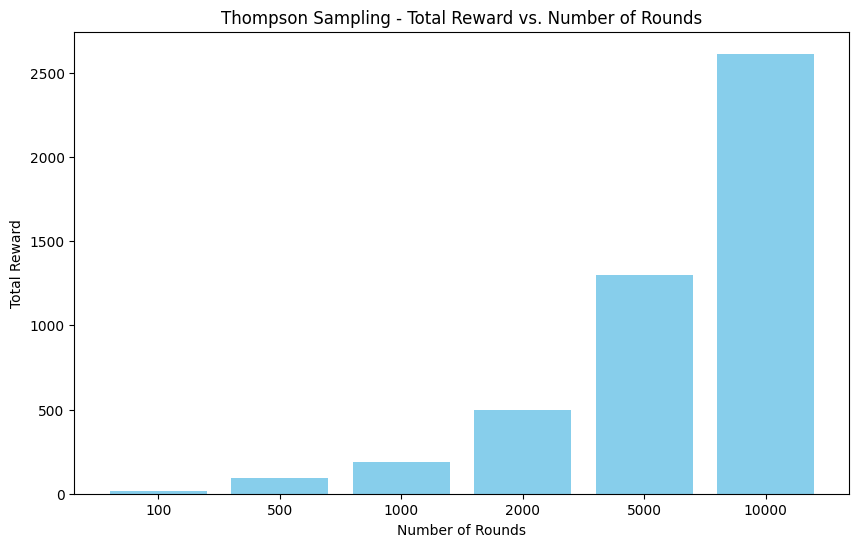

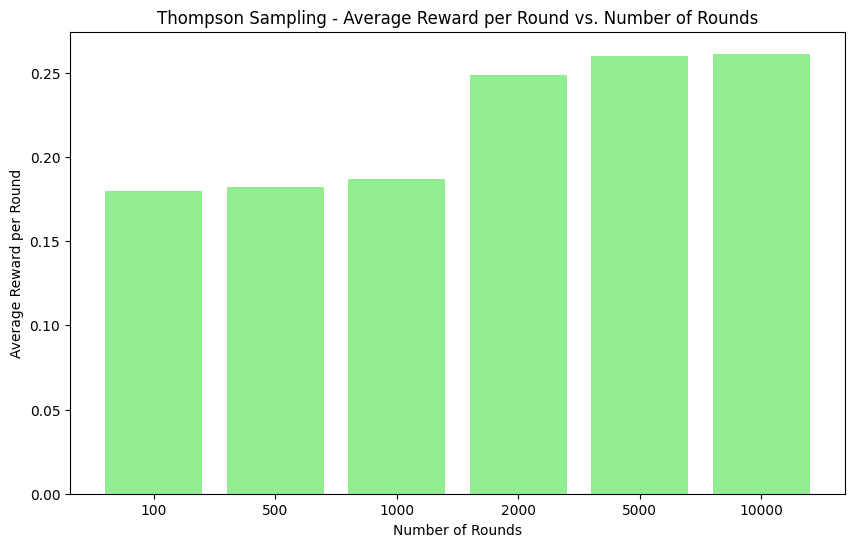

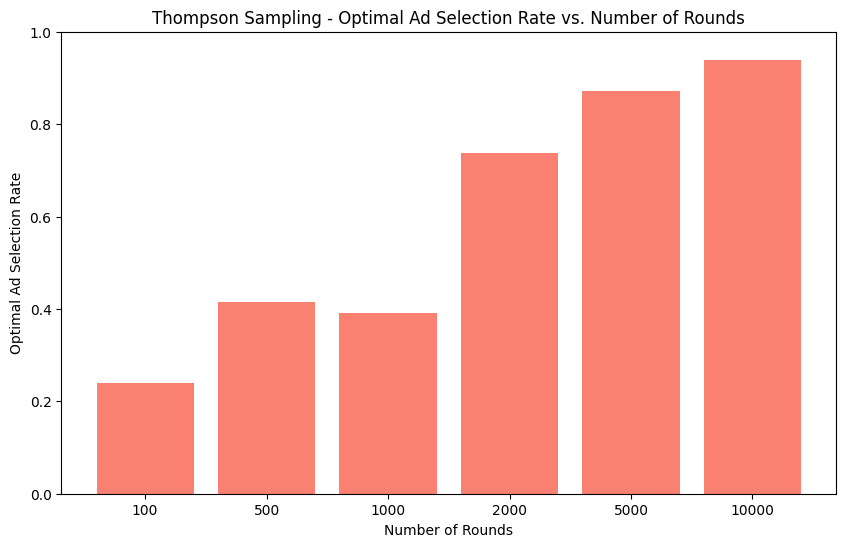

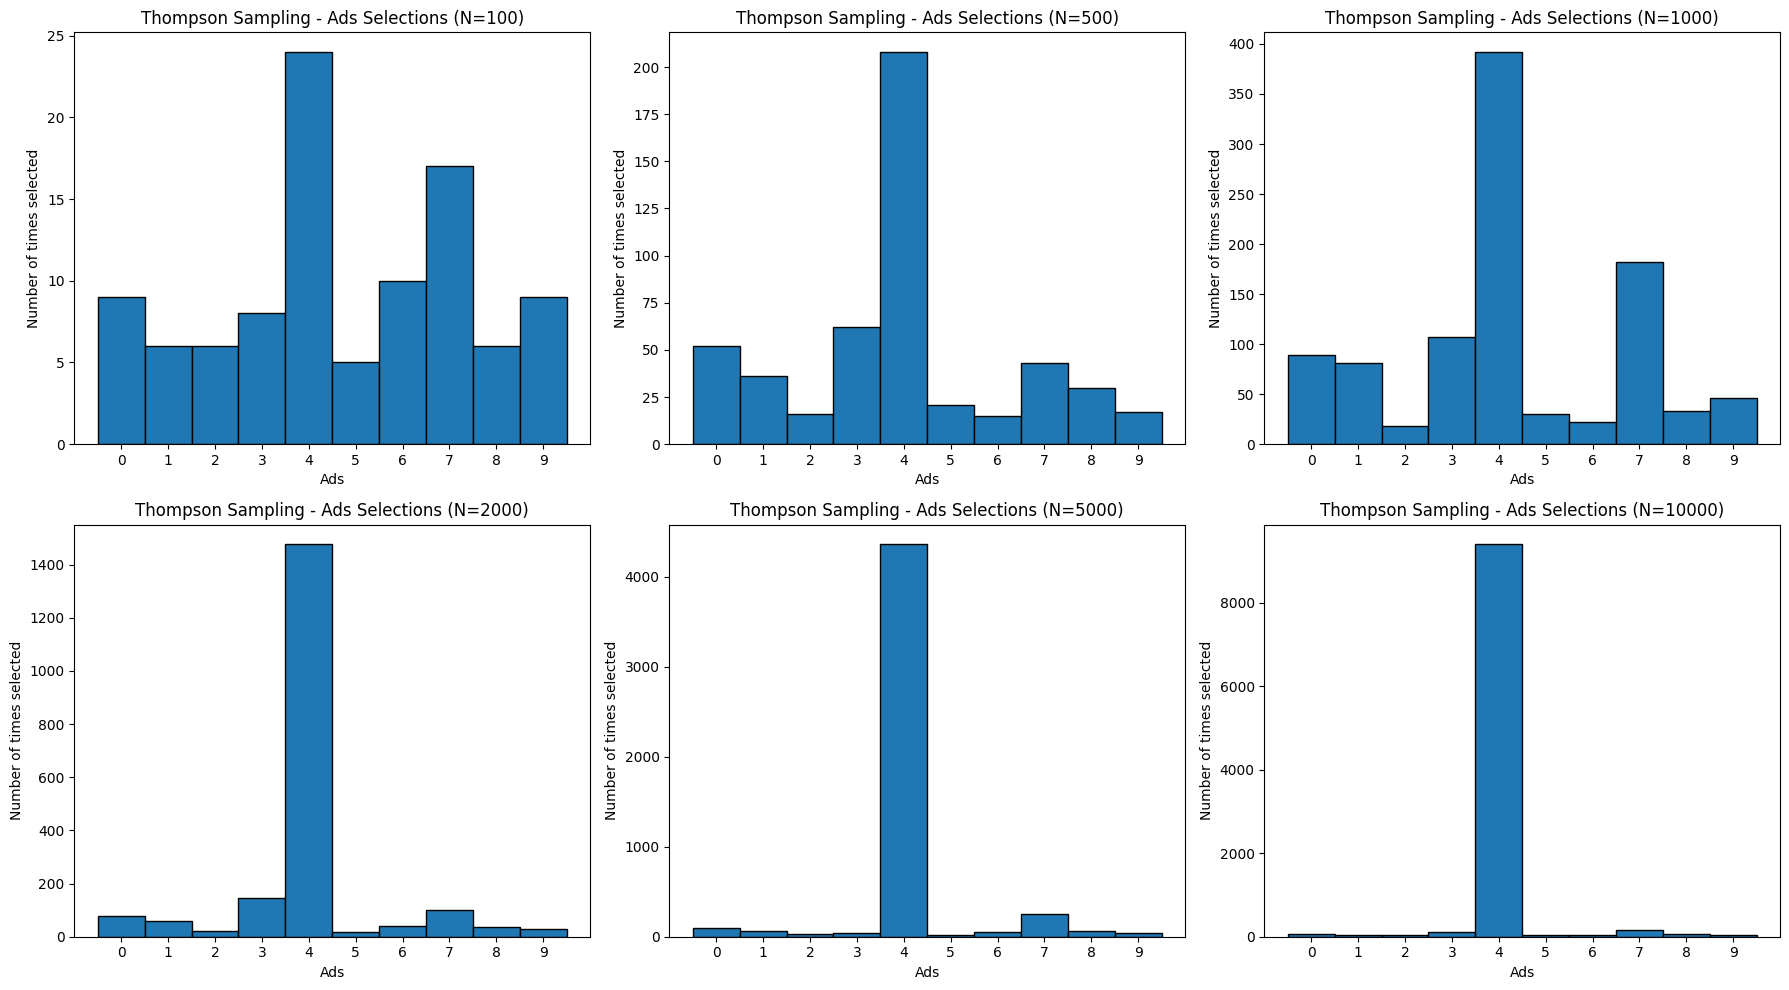

In [60]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

# Create the outputs directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# Import dataset
dataset = pd.read_csv('raw_data/Ads_CTR_Optimisation.csv')

# Function to run Thompson Sampling for a given number of rounds
def run_thompson_sampling(N, d):
    ads_selected = []
    numbers_of_rewards_1 = [0] * d
    numbers_of_rewards_0 = [0] * d
    total_reward = 0
    optimal_ad = np.argmax(dataset.mean().values)
    optimal_ad_selections = []
    for n in range(0, N):
        ad = 0
        max_random = 0
        for i in range(0, d):
            random_beta = random.betavariate(numbers_of_rewards_1[i] + 1, numbers_of_rewards_0[i] + 1)
            if random_beta > max_random:
                max_random = random_beta
                ad = i
        ads_selected.append(ad)
        reward = dataset.values[n % len(dataset), ad]
        if reward == 1:
            numbers_of_rewards_1[ad] += 1
        else:
            numbers_of_rewards_0[ad] += 1
        total_reward += reward
        # Record if the optimal ad was selected
        optimal_ad_selections.append(int(ad == optimal_ad))
    # Calculate the optimal ad selection rate
    optimal_selection_rate = sum(optimal_ad_selections) / N
    # Calculate the average reward per round
    average_reward_per_round = total_reward / N
    return total_reward, average_reward_per_round, optimal_selection_rate, ads_selected

# Testing different numbers of rounds for Thompson Sampling
rounds = [100, 500, 1000, 2000, 5000, 10000]
d = len(dataset.columns)
ts_total_rewards = []
ts_average_rewards_per_round = []
ts_optimal_ad_selection_rates = []
ts_ads_selected_list = []

for N in rounds:
    total_reward, avg_reward_per_round, optimal_selection_rate, ads_selected = run_thompson_sampling(N, d)
    ts_total_rewards.append(total_reward)
    ts_average_rewards_per_round.append(avg_reward_per_round)
    ts_optimal_ad_selection_rates.append(optimal_selection_rate)
    ts_ads_selected_list.append(ads_selected)
    print(f"Thompson Sampling - Rounds: {N}, Total Reward: {total_reward}, Average Reward per Round: {avg_reward_per_round:.4f}, Optimal Ad Selection Rate: {optimal_selection_rate:.4f}")

# Plotting Total Rewards as a Bar Plot for Thompson Sampling
plt.figure(figsize=(10, 6))
plt.bar([str(N) for N in rounds], ts_total_rewards, color='skyblue')
plt.title('Thompson Sampling - Total Reward vs. Number of Rounds')
plt.xlabel('Number of Rounds')
plt.ylabel('Total Reward')
plt.savefig('outputs/Thompson_total_reward_vs_rounds.png')
plt.show()
plt.close()

# Plotting Average Reward per Round as a Bar Plot for Thompson Sampling
plt.figure(figsize=(10, 6))
plt.bar([str(N) for N in rounds], ts_average_rewards_per_round, color='lightgreen')
plt.title('Thompson Sampling - Average Reward per Round vs. Number of Rounds')
plt.xlabel('Number of Rounds')
plt.ylabel('Average Reward per Round')
plt.savefig('outputs/Thompson_average_reward_per_round_vs_rounds.png')
plt.show()
plt.close()

# Plotting Optimal Ad Selection Rate as a Bar Plot for Thompson Sampling
plt.figure(figsize=(10, 6))
plt.bar([str(N) for N in rounds], ts_optimal_ad_selection_rates, color='salmon')
plt.title('Thompson Sampling - Optimal Ad Selection Rate vs. Number of Rounds')
plt.xlabel('Number of Rounds')
plt.ylabel('Optimal Ad Selection Rate')
plt.ylim(0, 1)
plt.savefig('outputs/Thompson_optimal_ad_selection_rate_vs_rounds.png')
plt.show()
plt.close()

# Plotting Histograms of Ads Selections for all runs in Thompson Sampling
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()
for idx, N in enumerate(rounds):
    ads_selected = ts_ads_selected_list[idx]
    axs[idx].hist(ads_selected, bins=np.arange(d+1)-0.5, edgecolor='black')
    axs[idx].set_title(f'Thompson Sampling - Ads Selections (N={N})')
    axs[idx].set_xlabel('Ads')
    axs[idx].set_ylabel('Number of times selected')
    axs[idx].set_xticks(range(d))
plt.tight_layout()
plt.savefig('outputs/Thompson_histograms_ads_selections_all_runs.png')
plt.show()
plt.close()


## Greedy Sampling

Greedy Strategy - Rounds: 100, Total Reward: 7, Average Reward per Round: 0.0700, Optimal Ad Selection Rate: 0.0100
Greedy Strategy - Rounds: 500, Total Reward: 79, Average Reward per Round: 0.1580, Optimal Ad Selection Rate: 0.0020
Greedy Strategy - Rounds: 1000, Total Reward: 157, Average Reward per Round: 0.1570, Optimal Ad Selection Rate: 0.0010
Greedy Strategy - Rounds: 2000, Total Reward: 339, Average Reward per Round: 0.1695, Optimal Ad Selection Rate: 0.0005
Greedy Strategy - Rounds: 5000, Total Reward: 845, Average Reward per Round: 0.1690, Optimal Ad Selection Rate: 0.0002
Greedy Strategy - Rounds: 10000, Total Reward: 1701, Average Reward per Round: 0.1701, Optimal Ad Selection Rate: 0.0001


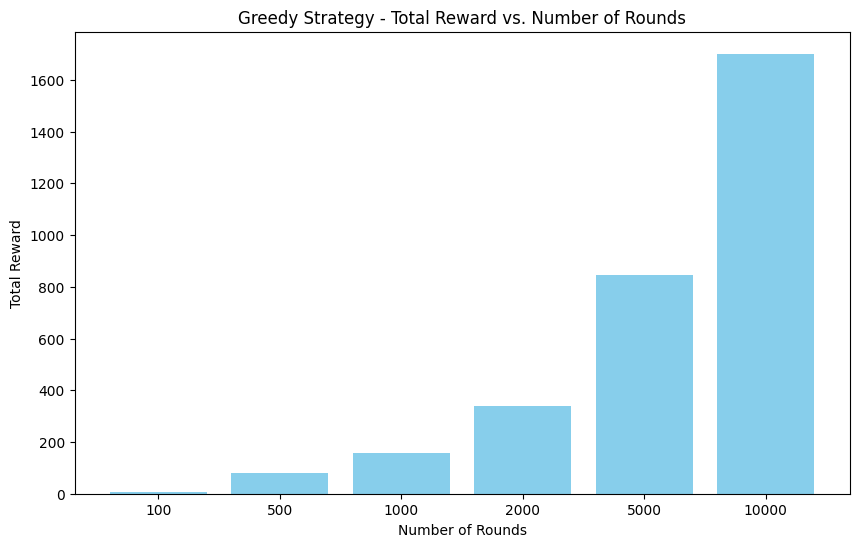

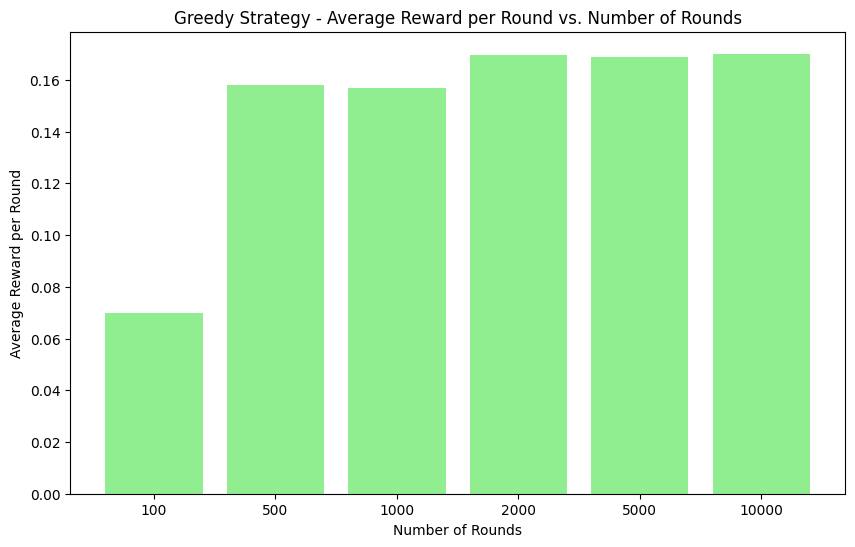

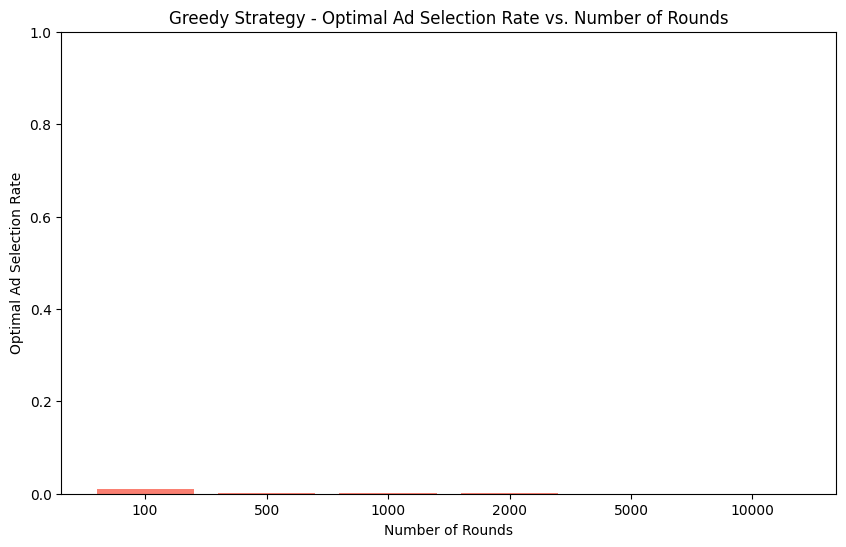

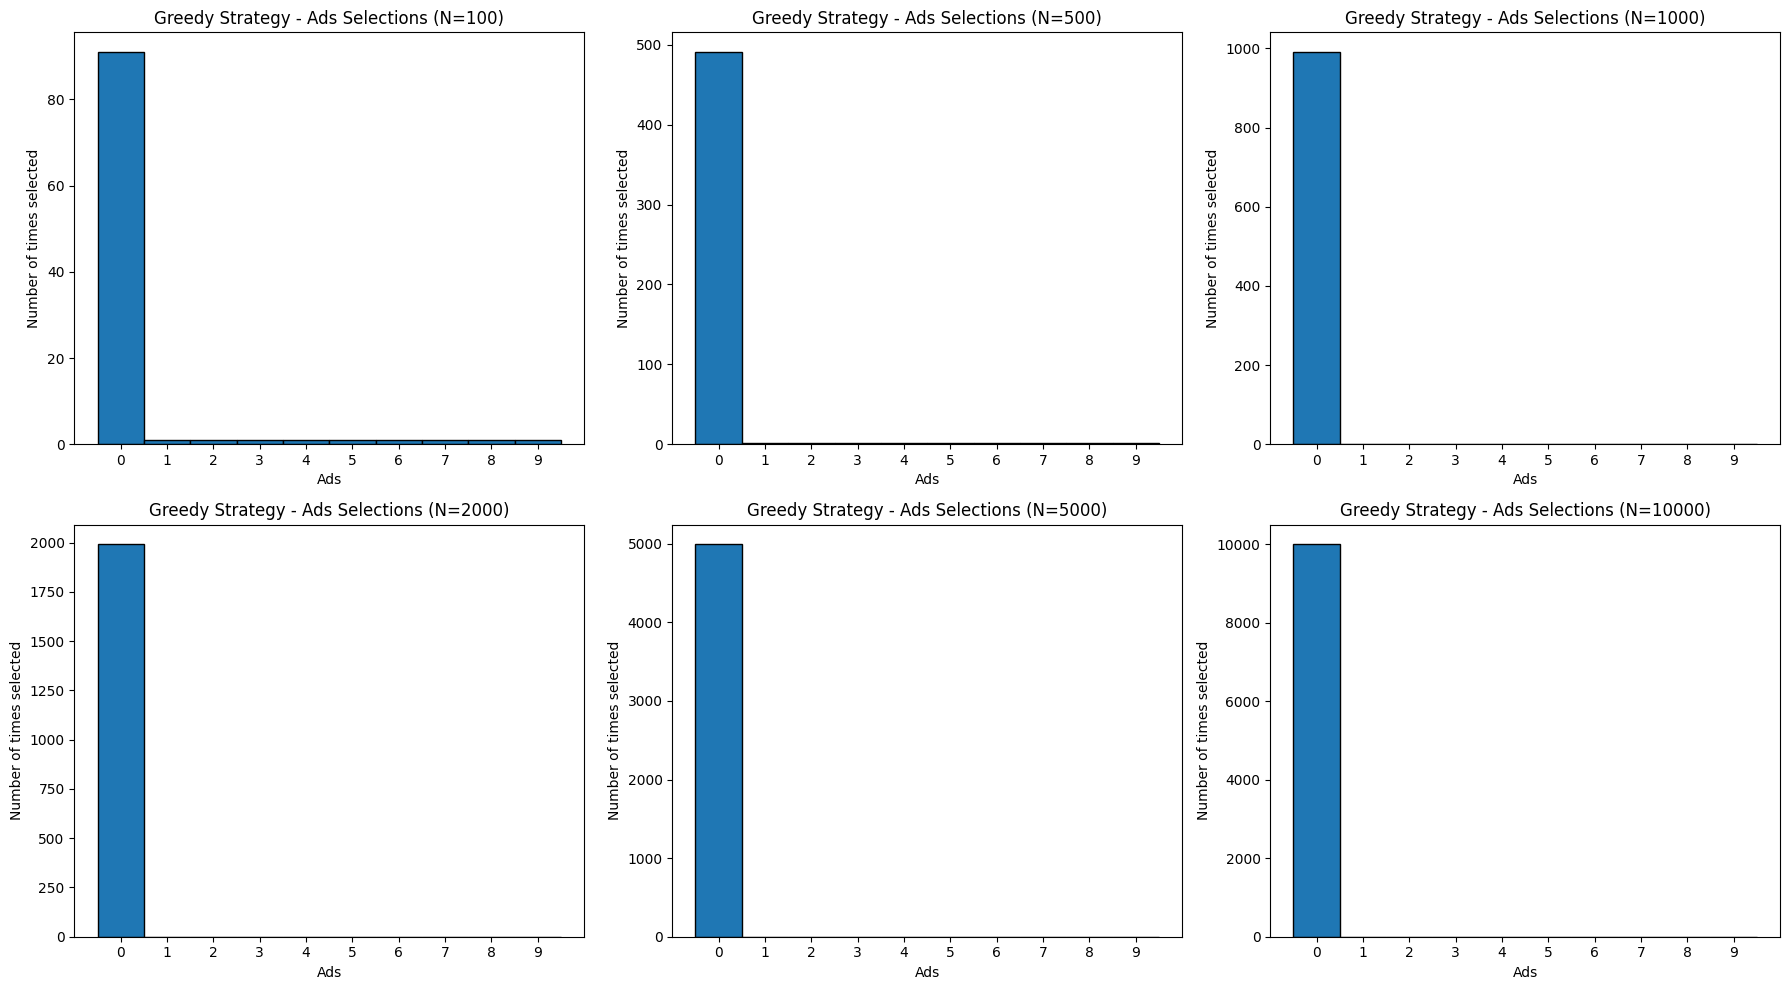

In [61]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Create the outputs directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# Import dataset
dataset = pd.read_csv('raw_data/Ads_CTR_Optimisation.csv')

# Function to run Greedy Strategy for a given number of rounds
def run_greedy(N, d):
    ads_selected = []
    numbers_of_selections = [0] * d
    sums_of_rewards = [0] * d
    total_reward = 0
    optimal_ad = np.argmax(dataset.mean().values)
    optimal_ad_selections = []
    for n in range(0, N):
        if n < d:
            ad = n  # Select each ad once
        else:
            average_rewards = [sums_of_rewards[i] / numbers_of_selections[i] if numbers_of_selections[i] > 0 else 0 for i in range(d)]
            ad = np.argmax(average_rewards)
        ads_selected.append(ad)
        numbers_of_selections[ad] += 1
        reward = dataset.values[n % len(dataset), ad]
        sums_of_rewards[ad] += reward
        total_reward += reward
        optimal_ad_selections.append(int(ad == optimal_ad))
    # Calculate the optimal ad selection rate
    optimal_selection_rate = sum(optimal_ad_selections) / N
    # Calculate the average reward per round
    average_reward_per_round = total_reward / N
    return total_reward, average_reward_per_round, optimal_selection_rate, ads_selected

# Testing different numbers of rounds for Greedy Strategy
rounds = [100, 500, 1000, 2000, 5000, 10000]
d = len(dataset.columns)
greedy_total_rewards = []
greedy_average_rewards_per_round = []
greedy_optimal_ad_selection_rates = []
greedy_ads_selected_list = []

for N in rounds:
    total_reward, avg_reward_per_round, optimal_selection_rate, ads_selected = run_greedy(N, d)
    greedy_total_rewards.append(total_reward)
    greedy_average_rewards_per_round.append(avg_reward_per_round)
    greedy_optimal_ad_selection_rates.append(optimal_selection_rate)
    greedy_ads_selected_list.append(ads_selected)
    print(f"Greedy Strategy - Rounds: {N}, Total Reward: {total_reward}, Average Reward per Round: {avg_reward_per_round:.4f}, Optimal Ad Selection Rate: {optimal_selection_rate:.4f}")

# Plotting Total Rewards as a Bar Plot for Greedy Strategy
plt.figure(figsize=(10, 6))
plt.bar([str(N) for N in rounds], greedy_total_rewards, color='skyblue')
plt.title('Greedy Strategy - Total Reward vs. Number of Rounds')
plt.xlabel('Number of Rounds')
plt.ylabel('Total Reward')
plt.savefig('outputs/Greedy_total_reward_vs_rounds.png')
plt.show()
plt.close()

# Plotting Average Reward per Round as a Bar Plot for Greedy Strategy
plt.figure(figsize=(10, 6))
plt.bar([str(N) for N in rounds], greedy_average_rewards_per_round, color='lightgreen')
plt.title('Greedy Strategy - Average Reward per Round vs. Number of Rounds')
plt.xlabel('Number of Rounds')
plt.ylabel('Average Reward per Round')
plt.savefig('outputs/Greedy_average_reward_per_round_vs_rounds.png')
plt.show()
plt.close()

# Plotting Optimal Ad Selection Rate as a Bar Plot for Greedy Strategy
plt.figure(figsize=(10, 6))
plt.bar([str(N) for N in rounds], greedy_optimal_ad_selection_rates, color='salmon')
plt.title('Greedy Strategy - Optimal Ad Selection Rate vs. Number of Rounds')
plt.xlabel('Number of Rounds')
plt.ylabel('Optimal Ad Selection Rate')
plt.ylim(0, 1)
plt.savefig('outputs/Greedy_optimal_ad_selection_rate_vs_rounds.png')
plt.show()
plt.close()

# Plotting Histograms of Ads Selections for all runs in Greedy Strategy
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()
for idx, N in enumerate(rounds):
    ads_selected = greedy_ads_selected_list[idx]
    axs[idx].hist(ads_selected, bins=np.arange(d+1)-0.5, edgecolor='black')
    axs[idx].set_title(f'Greedy Strategy - Ads Selections (N={N})')
    axs[idx].set_xlabel('Ads')
    axs[idx].set_ylabel('Number of times selected')
    axs[idx].set_xticks(range(d))
plt.tight_layout()
plt.savefig('outputs/Greedy_histograms_ads_selections_all_runs.png')
plt.show()
plt.close()


## Compare to UCB and Thompson Sampling to Greedy sampling

Greedy Strategy - Total Reward: 1701, Average Reward per Round: 0.1701, Optimal Ad Selection Rate: 0.0001
UCB Algorithm - Total Reward: 2178, Average Reward per Round: 0.2178, Optimal Ad Selection Rate: 0.6323
Thompson Sampling - Total Reward: 2606, Average Reward per Round: 0.2606, Optimal Ad Selection Rate: 0.9078


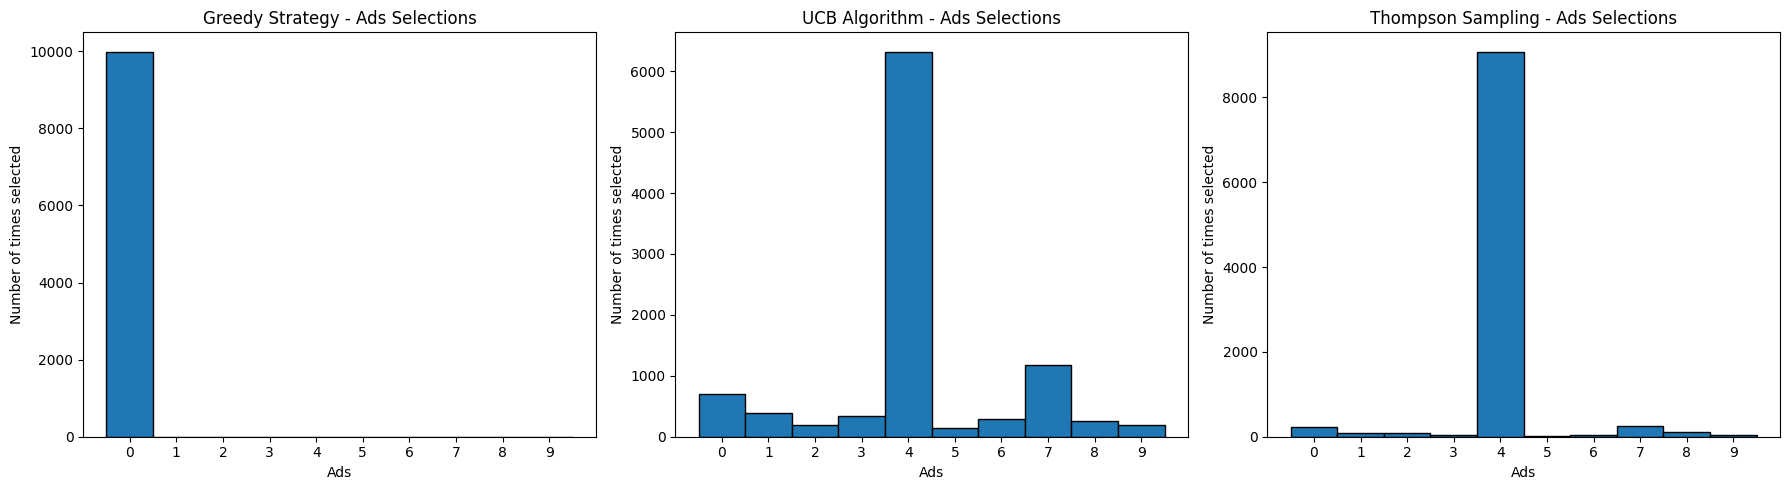

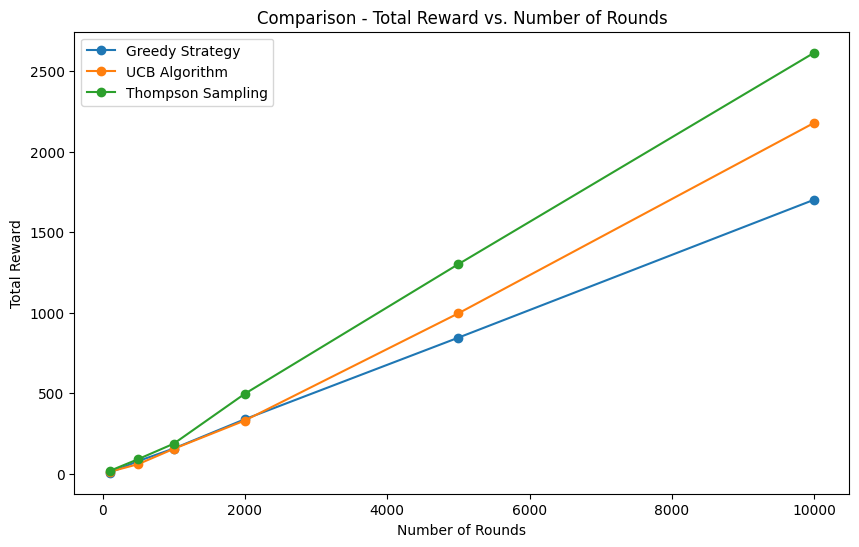

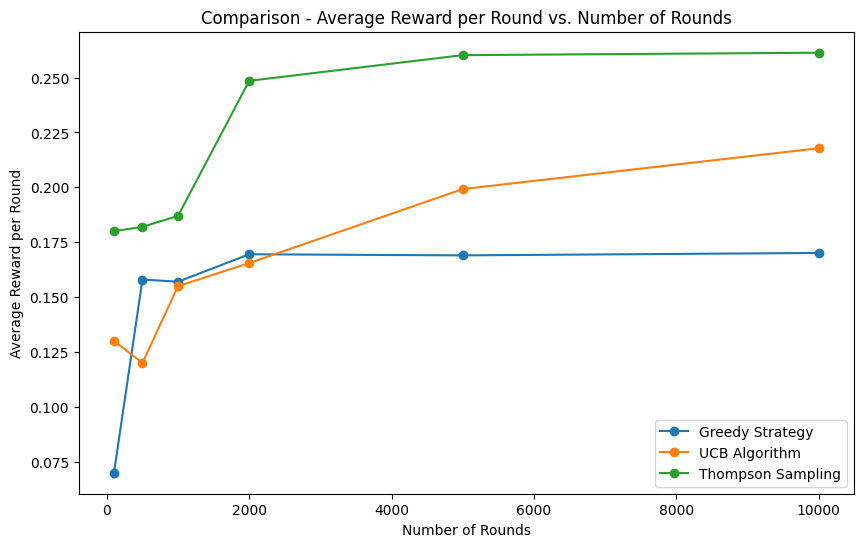

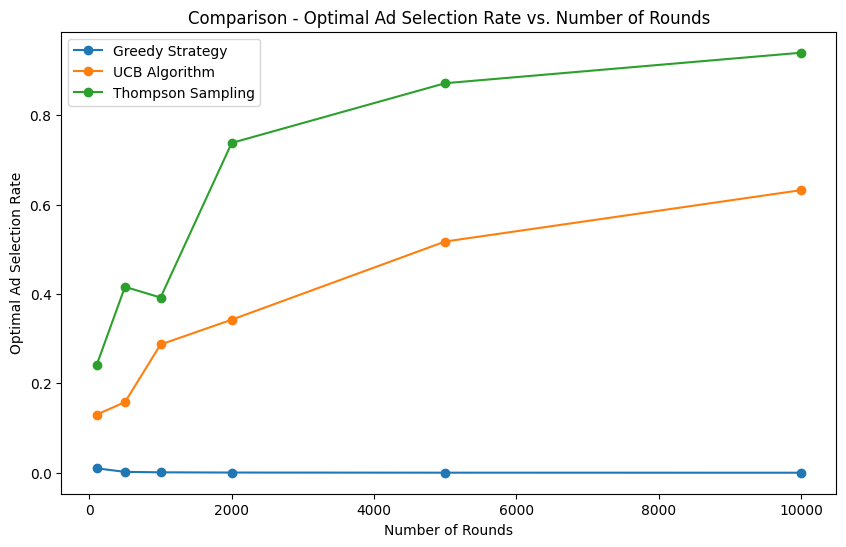

In [62]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import os

# Create the outputs directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# Import dataset
dataset = pd.read_csv('raw_data/Ads_CTR_Optimisation.csv')
d = len(dataset.columns)

# Function to run Greedy Strategy
def run_greedy(N, d):
    ads_selected = []
    numbers_of_selections = [0] * d
    sums_of_rewards = [0] * d
    total_reward = 0
    optimal_ad = np.argmax(dataset.mean().values)
    optimal_ad_selections = []
    for n in range(0, N):
        if n < d:
            ad = n  # Select each ad once
        else:
            average_rewards = [sums_of_rewards[i] / numbers_of_selections[i] if numbers_of_selections[i] > 0 else 0 for i in range(d)]
            ad = np.argmax(average_rewards)
        ads_selected.append(ad)
        numbers_of_selections[ad] += 1
        reward = dataset.values[n % len(dataset), ad]
        sums_of_rewards[ad] += reward
        total_reward += reward
        optimal_ad_selections.append(int(ad == optimal_ad))
    # Calculate the optimal ad selection rate
    optimal_selection_rate = sum(optimal_ad_selections) / N
    # Calculate the average reward per round
    average_reward_per_round = total_reward / N
    return total_reward, average_reward_per_round, optimal_selection_rate, ads_selected

# Run Greedy Strategy
greedy_total_reward, greedy_avg_reward_per_round, greedy_optimal_selection_rate, ads_selected_greedy = run_greedy(10000, d)
print(f"Greedy Strategy - Total Reward: {greedy_total_reward}, Average Reward per Round: {greedy_avg_reward_per_round:.4f}, Optimal Ad Selection Rate: {greedy_optimal_selection_rate:.4f}")

# Run UCB
ucb_total_reward, ucb_avg_reward_per_round, ucb_optimal_selection_rate, ads_selected_ucb = run_ucb(10000, d)
print(f"UCB Algorithm - Total Reward: {ucb_total_reward}, Average Reward per Round: {ucb_avg_reward_per_round:.4f}, Optimal Ad Selection Rate: {ucb_optimal_selection_rate:.4f}")

# Run Thompson Sampling
ts_total_reward, ts_avg_reward_per_round, ts_optimal_selection_rate, ads_selected_ts = run_thompson_sampling(10000, d)
print(f"Thompson Sampling - Total Reward: {ts_total_reward}, Average Reward per Round: {ts_avg_reward_per_round:.4f}, Optimal Ad Selection Rate: {ts_optimal_selection_rate:.4f}")

# Cumulative Rewards
cumulative_rewards_greedy = np.cumsum([dataset.values[n % len(dataset), ad] for n, ad in enumerate(ads_selected_greedy)])
cumulative_rewards_ucb = np.cumsum([dataset.values[n % len(dataset), ad] for n, ad in enumerate(ads_selected_ucb)])
cumulative_rewards_ts = np.cumsum([dataset.values[n % len(dataset), ad] for n, ad in enumerate(ads_selected_ts)])

# Plotting Histogram of Ads Selections for all algorithms
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Greedy Strategy
axs[0].hist(ads_selected_greedy, bins=np.arange(d+1)-0.5, edgecolor='black')
axs[0].set_title('Greedy Strategy - Ads Selections')
axs[0].set_xlabel('Ads')
axs[0].set_ylabel('Number of times selected')
axs[0].set_xticks(range(d))

# UCB Algorithm
axs[1].hist(ads_selected_ucb, bins=np.arange(d+1)-0.5, edgecolor='black')
axs[1].set_title('UCB Algorithm - Ads Selections')
axs[1].set_xlabel('Ads')
axs[1].set_ylabel('Number of times selected')
axs[1].set_xticks(range(d))

# Thompson Sampling
axs[2].hist(ads_selected_ts, bins=np.arange(d+1)-0.5, edgecolor='black')
axs[2].set_title('Thompson Sampling - Ads Selections')
axs[2].set_xlabel('Ads')
axs[2].set_ylabel('Number of times selected')
axs[2].set_xticks(range(d))

plt.tight_layout()
plt.savefig('outputs/Comparison_histograms_ads_selections.png')
plt.show()
plt.close()

# Comparison of Total Rewards over Rounds for all Algorithms
plt.figure(figsize=(10, 6))
plt.plot(rounds, greedy_total_rewards, marker='o', label='Greedy Strategy')
plt.plot(rounds, ucb_total_rewards, marker='o', label='UCB Algorithm')
plt.plot(rounds, ts_total_rewards, marker='o', label='Thompson Sampling')
plt.title('Comparison - Total Reward vs. Number of Rounds')
plt.xlabel('Number of Rounds')
plt.ylabel('Total Reward')
plt.legend()
plt.savefig('outputs/Comparison_total_reward_vs_rounds.png')
plt.show()
plt.close()

# Comparison of Average Rewards per Round for all Algorithms
plt.figure(figsize=(10, 6))
plt.plot(rounds, greedy_average_rewards_per_round, marker='o', label='Greedy Strategy')
plt.plot(rounds, ucb_average_rewards_per_round, marker='o', label='UCB Algorithm')
plt.plot(rounds, ts_average_rewards_per_round, marker='o', label='Thompson Sampling')
plt.title('Comparison - Average Reward per Round vs. Number of Rounds')
plt.xlabel('Number of Rounds')
plt.ylabel('Average Reward per Round')
plt.legend()
plt.savefig('outputs/Comparison_average_reward_per_round_vs_rounds.png')
plt.show()
plt.close()

# Comparison of Optimal Ad Selection Rates for all Algorithms
plt.figure(figsize=(10, 6))
plt.plot(rounds, greedy_optimal_ad_selection_rates, marker='o', label='Greedy Strategy')
plt.plot(rounds, ucb_optimal_ad_selection_rates, marker='o', label='UCB Algorithm')
plt.plot(rounds, ts_optimal_ad_selection_rates, marker='o', label='Thompson Sampling')
plt.title('Comparison - Optimal Ad Selection Rate vs. Number of Rounds')
plt.xlabel('Number of Rounds')
plt.ylabel('Optimal Ad Selection Rate')
plt.legend()
plt.savefig('outputs/Comparison_optimal_ad_selection_rate_vs_rounds.png')
plt.show()
plt.close()
